In [117]:
import numpy as np
def float_rand(a=0, b=1, size=None):
    """
    Returns a floating random number uniformly sampled from [a, b).
    
    Args:
        a, b: the interval limits
        size: the return array size (use None for a single value)
    """
    
    return np.random.random_sample(size) * (b - a) + a

def int_rand(a=0, b=0, size=None):
    """
    Returns an integer random number uniformly sampled from [a, b].
    
    Args:
        a, b: the interval limits
        size: the return array size (use None for a single value)
    """
    
    return np.random.randint(a, b + 1, size)

def prob_choice(p):
    """
    Return True if a random number drawn from [0, 1) is less than p.
    
    Args:
        p: the probability
    """
    
    return np.random.random_sample() < p

In [179]:
from PIL import Image
class Letterbox(object):
    """
    A minimal letterbox class.
    """
    
    def __init__(self, img):
        self._img = img.copy()
        self.transforms_ = [] # the log of the image transformations
        self.fill_color_ = (0, 0, 0)
        
    def __getattr__(self, key):
        if key == '_img':
            raise AttributeError()
        return getattr(self._img, key)
    
    def letterbox(self, sizew=224,sizeh=224, augments=None, randomize_pos=False, fill_letterbox=False):
        """
        The letterboxing routine. It is assumed that the geometric augmentation have been performed.
        
        Args:
            sizew, sizeh: the target image sizes
            augments: the image augmentation parameters (ignored in this class)
            randomize_pos: randomize the position within letterbox (if possible)
            fill_letterbox: enlarge small images to fill the letterbox
        """

        # compute the new image scale
        scale = min([sizew / self._img.width, sizeh / self._img.height])
        
        # rescale the image if it is too large
        if scale < 1:
            self._img = self._img.resize((int(scale * self._img.width), int(scale * self._img.height)), Image.BILINEAR)
            scale_ = scale
            
        # rescake the image if it is too small and the letterbox should be filled
        if fill_letterbox and scale > 1:
            self._img = self._img.resize((int(scale * self._img.width), int(scale * self._img.height)), Image.NEAREST)
            scale_ = scale
        else:
            scale_ = 1
             
        # compute the image position
        if randomize_pos:
            dx = np.random.randint(0, sizew - self._img.width + 1)
            dy = np.random.randint(0, sizeh - self._img.height + 1)
        else:
            dx = (sizew - self._img.width) // 2
            dy = (sizeh - self._img.height) // 2
                        
        # append the final transformation
        self.transforms_.append({'scale_shift':[scale_, scale_, dx, dy]})
        
        # paste the rescaled image
        new_img = Image.new('RGB', (sizew, sizeh), self.fill_color_)
        new_img.paste(self._img, (dx, dy))
        self._img = new_img

In [235]:
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

class AugmentedLetterbox(Letterbox):
    """
    A letterbox class that augments (geometry and color).
    """
    
    def __init__(self, img):
        super().__init__(img)
        
    def __getattr__(self, key):
        if key == '_img':
            raise AttributeError()
        return getattr(self._img, key)
    
    def letterbox(self, sizew=224,sizeh=224, augments=None, randomize_pos=False, fill_letterbox=False):
        """
        The letterboxing routine. It is assumed that the geometric augmentation have been performed.
        
        Args:
            sizew, sizeh: the target image sizes
            augments: the image augmentation parameters
            randomize_pos: randomize the position within letterbox (if possible)
            fill_letterbox: enlarge small images to fill the letterbox
        """

        # geometry augmentation
        if augments:
            self.geo_aug(augments)
        
        # call the final letterbox
        super().letterbox(sizew=sizew, sizeh=sizeh, augments=None, randomize_pos=randomize_pos, fill_letterbox=fill_letterbox)
        
        # colour augmentation
        if augments:
            self.col_aug(augments)
        
    def geo_aug(self, augments):
        """
        The geometric augmentations.
        
        Args:
            augments: a dictionary containing the augments
        """
        
        if not augments:
            return
        
        # scale
        if 'scale_prob' in augments:
            if prob_choice(augments['scale_prob']):
                
                # choose a random scaling factor
                scale = float_rand(augments['scale_min'], augments['scale_max'])
                
                # rescale image
                if scale < 1:
                    self._img = self._img.resize((int(scale * self._img.width), int(scale * self._img.height)), Image.BILINEAR)
                elif scale > 1:
                    self._img = self._img.resize((int(scale * self._img.width), int(scale * self._img.height)), Image.NEAREST)
                
                # log transform
                self.transforms_.append({'scale_shift':[scale, scale, 0, 0]})
                
        # crop
        if 'crop_prob' in augments:
            if prob_choice(augments['crop_prob']):
                # choose random horizontal and vertical crop sizes
                crop_width = int(np.sqrt(float_rand(1 - augments['crop_frac'], 1)) * self._img.width)
                crop_height = int(np.sqrt(float_rand(1 - augments['crop_frac'], 1)) * self._img.height)
                
                # choose random crop position
                dx = int_rand(0, max([0, self._img.width - crop_width]))
                dy = int_rand(0, max([0, self._img.height - crop_height]))
                
                # crop
                self._img = self._img.crop((dx, dy, crop_width, crop_height))
                
                # log transforms
                self.transforms_.append({'crop':[dx, dy, crop_width, crop_height]})
                
        # change aspect ratio (jitter)
        if 'jitter_prob' in augments:
            if prob_choice(augments['jitter_prob']):
                
                jitter_size = float_rand(1 - augments['jitter'], 1 + augments['jitter'])
                
                if prob_choice(0.5):
                    new_width = int(self._img.width * jitter_size)
                    new_height = self._img.height
                else:
                    new_width = self._img.width
                    new_height = int(self._img.height * jitter_size)
                
                # log transforms
                self.transforms_.append({'scale_shift':[new_width / self._img.width, new_height / self._img.height, 0, 0]})
                
                # rescale
                self._img = self._img.resize((new_width, new_height), Image.BILINEAR)
                
        # rotate
        if 'rotate_prob' in augments:
            if prob_choice(augments['rotate_prob']):
                
                # choose a random rotatation angle
                rotate_angle = int_rand(-augments['rotate_angle'], augments['rotate_angle'])
            
                # rotate
                self._img = self._img.rotate(rotate_angle, expand=augments['rotate_expand'])
            
                # log transforms
                self.transforms_.append({'rotation':[rotate_angle, augments['rotate_expand']]})
                
        # horizontal flip
        if 'hflip_prob' in augments:
            if prob_choice(augments['hflip_prob']):
                self._img = self._img.transpose(Image.FLIP_LEFT_RIGHT)
                self.transforms_.append({'flip':['horizontal']})
                
        # vertical flip
        if 'vflip_prob' in augments:
            if prob_choice(augments['vflip_prob']):
                self._img = self._img.transpose(Image.FLIP_TOP_BOTTOM)
                self.transforms_.append({'flip':['vertical']})

                
        
    def col_aug(self, augments):
        """
        The color augmentations.
        
        Args:
            augments: a dictionary containing the augments
        """
        
        touch_colors = False
        if 'hue' in augments:
            hue_factor = float_rand(-augments['hue'], augments['hue'])
            touch_colors = True
        else:
            hue_factor = 1
            
        if 'saturation' in augments:
            saturation_factor = float_rand(1, 1 + augments['saturation']) if prob_choice(0.5) else 1 / float_rand(1, 1 + augments['saturation'])
            touch_colors = True
        else:
            saturation_factor = 1
            
        if 'value' in augments:
            value_factor = float_rand(1, 1 + augments['value']) if prob_choice(0.5) else 1 / float_rand(1, 1 + augments['saturation'])
            touch_colors = True
        else:
            value_factor = 1


        if touch_colors:
            x = rgb_to_hsv(np.array(self._img)/255.)
            x[..., 0] += hue_factor
            x[..., 0][x[..., 0]>1] -= 1
            x[..., 0][x[..., 0]<0] += 1

            x[..., 1] *= saturation_factor
            x[..., 2] *= value_factor
            x[x>1] = 1
            x[x<0] = 0

            self._img = Image.fromarray(np.uint8(hsv_to_rgb(x) * 255))
            
            self.transforms_.append({'color':[hue_factor, saturation_factor, value_factor]})

In [240]:
img = Image.open('Valencia_Sightseeing_0001_(203798303).jpeg')
lbimg = AugmentedLetterbox(img)

lbimg.letterbox(608, 608, augments={'hue':0.2, 'saturation':0.5, 'value':0.5, 'hflip_prob':0.5, 'vflip_prob':0.5, 'rotate_prob':0.3, 'rotate_angle':20, 'rotate_expand':1, 'jitter_prob':0.2, 'jitter':0.4, 'scale_prob':0.2, 'scale_min':0.1, 'scale_max':0.2}, randomize_pos=True)

2048 1365
608 608
[{'scale_shift': [0.11083707200414777, 0.11083707200414777, 0, 0]}, {'scale_shift': [1.0, 0.8410596026490066, 0, 0]}, {'rotation': [4, 1]}, {'flip': ['horizontal']}, {'flip': ['vertical']}, {'scale_shift': [1, 1, 49, 385]}, {'color': [-0.013597308150494036, 0.6707571929587227, 0.9718596548411932]}]


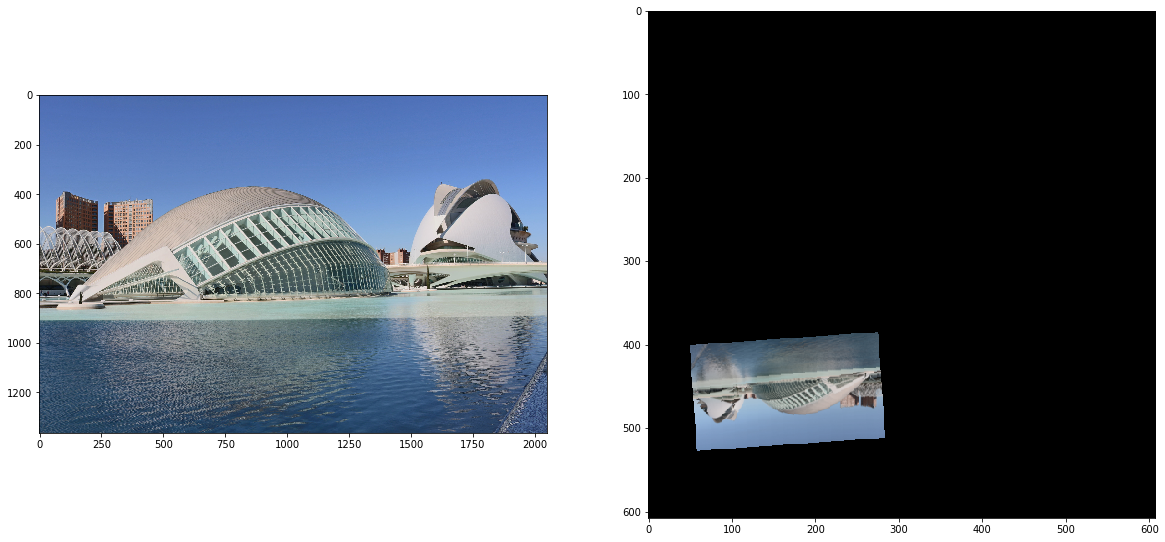

In [241]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 15))
ax[0].imshow(img)
ax[1].imshow(lbimg)
print('{} {}'.format(img.width, img.height))
print('{} {}'.format(lbimg.width, lbimg.height))
print(lbimg.transforms_)

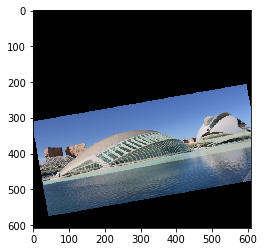

In [184]:
plt.imshow(lbimg.rotate(10, expand=0))